<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [7]:
import numpy as np

from matplotlib.patches import Ellipse

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib
from matplotlib.animation import FuncAnimation

import pandas as pd
import os

from border import Border
import constants as cs
from agent import Agent

from matplotlib import rc
##rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)


def norm(array):
    return np.sqrt(array[0]**2 + array[1]**2)

fontsize = 14
labelsize = 14
pad = 6
color = "mediumvioletred"
cmap = matplotlib.cm.get_cmap("viridis")


In [8]:
sim_code = "0828/sim_S1000A100_V_ZERO2.1sc4"
log_path = "./log/" + sim_code + "/"

df = pd.read_csv(log_path + "tracks.csv")

# Get number of time steps:
M = len(df[df["agent_id"] == 0])
N = len(df[df["step"] == 0])

df = df[df.step != 0]
df

agent_id  step  position_x  position_y  velocity_x  velocity_y  \
100          75     1  551.528748  325.702053    1.359613    0.000000   
101          30     1  460.622108  325.628733    1.604708    0.000000   
102          66     1  533.346625  325.351293    1.329156    0.000000   
103           6     1  412.134544  325.220746    1.333162    0.000000   
104           3     1  406.072582  325.760704    1.197637    0.000000   
...         ...   ...         ...         ...         ...         ...   
99995        20   999  454.600489  325.477010    1.421066    0.000000   
99996        83   999  580.373907  325.765396    1.272170    0.001042   
99997        68   999  550.690006  325.932186    1.332960    0.000000   
99998        56   999  532.831564  326.057864    1.969226    0.060889   
99999        45   999  502.322155  325.533538    1.102024   -0.059116   

       resultant_x  resultant_y  time_relaxation_x  time_relaxation_y  \
100       0.000000     0.000000           0.000000           0.000000   
101       0.000000     0.000000           0.000000           0.000000   
102       0.000000     0.000000           0.000000           0.000000   
103       0.000000     0.000000           0.000000           0.000000   
104       0.000000     0.000000           0.000000           0.000000   
...            ...          ...                ...                ...   
99995     0.000000     0.000000           0.000000           0.000000   
99996     0.000304     0.000195          -0.004114          -0.002083   
99997     0.000000     0.000000           0.000000           0.000000   
99998    -0.042529    -0.016685           0.045879          -0.121778   
99999    -0.022297    -0.008444           0.013466           0.118233   

       agent_repulsion_x  agent_repulsion_y  border_repulsion_x  \
100             0.000000           0.000000                   0   
101             0.000000           0.000000                   0   
102             0.000000           0.000000                   0   
103             0.000000           0.000000                   0   
104             0.000000           0.000000                   0   
...                  ...                ...                 ...   
99995           0.000000           0.000000                   0   
99996           0.004418           0.002279                   0   
99997           0.000000           0.000000                   0   
99998          -0.088408           0.105094                   0   
99999          -0.035763          -0.126677                   0   

       border_repulsion_y  resultant_mag  velocity_mag  agent_repulsion_mag  \
100                     0            0.0      1.359613                  0.0   
101                     0            0.0      1.604708                  0.0   
102                     0            0.0      1.329156                  0.0   
103                     0            0.0      1.333162                  0.0   
104                     0            0.0      1.197637                  0.0   
...                   ...            ...           ...                  ...   
99995                   0            NaN           NaN                  NaN   
99996                   0            NaN           NaN                  NaN   
99997                   0            NaN           NaN                  NaN   
99998                   0            NaN           NaN                  NaN   
99999                   0            NaN           NaN                  NaN   

       time_relaxation_mag  border_repulsion_mag  
100                    0.0                   0.0  
101                    0.0                   0.0  
102                    0.0                   0.0  
103                    0.0                   0.0  
104                    0.0                   0.0  
...                    ...                   ...  
99995                  NaN                   NaN  
99996                  NaN                   NaN  
99997                  NaN              

In [9]:
cs.BORDERS = pd.read_csv("./borders_grid.csv")

borders = []

for index, row in cs.BORDERS.iterrows(): 
    uid = index
            
    if row["shape"] == "line":
            
        x1 = row["x1"]
        y1 = row["y1"]
        x2 = row["x2"]
        y2 = row["y2"]
                
        Qx = np.linspace(start=x1, stop=x2, num=50)
        Qy = np.linspace(start=y1, stop=y2, num=50)

    borders.append(Border(uid, Qx, Qy))



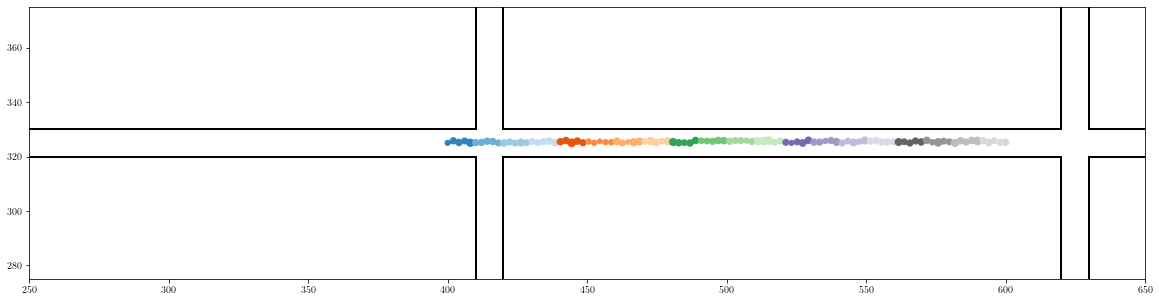

In [17]:
cmap = matplotlib.cm.get_cmap("tab20c")


class dot():
    def __init__(self, i):
            
        self.subset = df[df["agent_id"] == i]
                
        first_step = self.subset[self.subset["step"] == 1]
        self.x = first_step["position_x"]
        self.y = first_step["position_y"]
        self.speed = float(first_step["velocity_mag"].values)
        self.color = cmap(i/N)
        
    def move(self, f):
        step = self.subset[self.subset["step"] == f+1]
        new_pos = step.iloc[:,2:4].values
        self.x = new_pos[0,0]
        self.y = new_pos[0,1]
        self.speed = float(step["velocity_mag"].values)
            
        
dots = []

i = 0
for i in range(N):
    dots.append(dot(i))
    i = i + 1    

# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure(figsize = [20,5])
ax = plt.axes(xlim=(250, 650), ylim=(275, 375))

for border in borders:
    Q = np.array([border.Qx, border.Qy]).T
    ax.plot(Q[:,0], Q[:,1], linewidth = 2, linestyle = '-', color = "black")

for dot in dots:
    d = ax.scatter(dot.x, dot.y, color = "white")
    # ax.vlines(x = 2, ymin = 0, ymax = 11, linewidth = 2)
    # ax.vlines(x = 2, ymin = 20, ymax = 12, linewidth = 2)
    # ax.vlines(x = 0, ymin = 0, ymax = 10, linewidth = 2, linestyles = "dotted")
    # ax.vlines(x = 10, ymin = 0, ymax = 10, linewidth = 2, linestyles = "dotted")

        
# animation function.  This is called sequentially
def animate(f):
    speeds = []
    positions = []
    colors = []
    for dot in dots:
        # we will move the dot to the next step:
        dot.move(f)
        positions.append([dot.x, dot.y])
        colors.append(dot.color)
        speeds.append(dot.speed*30)
            
    positions = np.array(positions)

    d.set_offsets(positions)
    d.set_edgecolors(colors)
    d.set_facecolors(colors)
    d.set_sizes(speeds)
        
# call the animator.  blit=True means only re-draw the parts that have changed.
anim = FuncAnimation(fig, animate, frames=M-1, interval=10)
#anim.save("movie.mp4", writer='mencoder'

filename = log_path + "animate.mp4"
anim.save(filename, writer='ffmpeg', dpi=200)


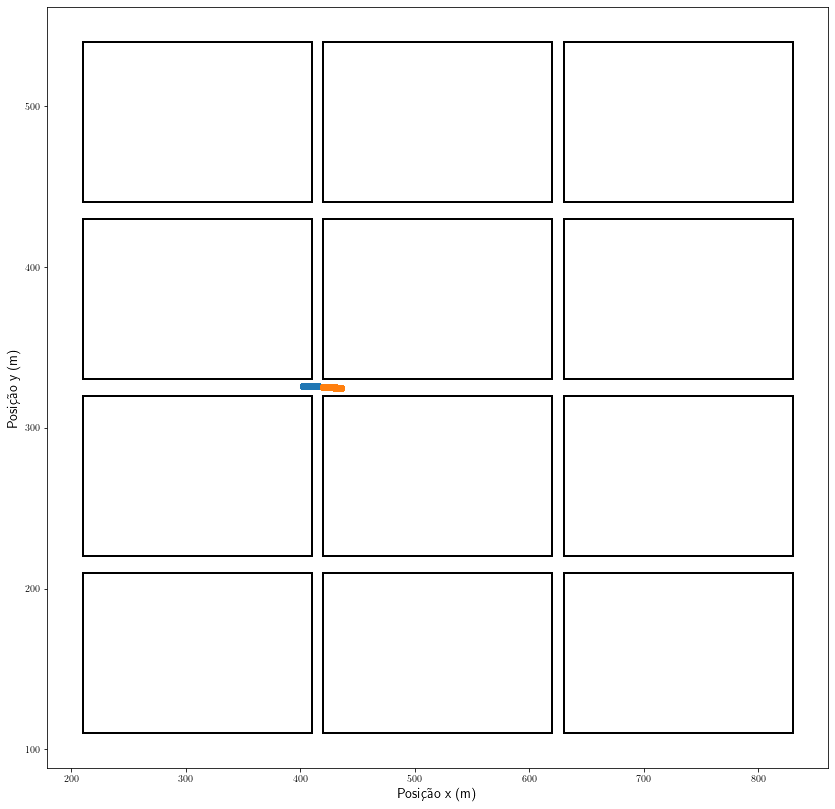

In [13]:
fig, ax = plt.subplots(figsize = [14,14])
    
for border in borders:
    Q = np.array([border.Qx, border.Qy]).T
    ax.plot(Q[:,0], Q[:,1], linewidth = 2, linestyle = '-', color = "black")
    
ax.set_xlabel("Posição x (m)", fontsize = fontsize)
ax.set_ylabel("Posição y (m)", fontsize = fontsize)

subset = df[df["agent_id"] == 1]
ax.scatter(subset["position_x"], subset["position_y"])


subset = df[df["agent_id"] == 10]
ax.scatter(subset["position_x"], subset["position_y"])